In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torch.nn as nn

In [9]:
class ResidualBlock(nn.Module):
    def __init__(self, dim, dropout):
        super().__init__()
        self.ln = nn.LayerNorm(dim)
        self.fc = nn.Linear(dim, dim)
        self.gelu = nn.GELU()
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        residual = x
        out = self.ln(x)
        out = self.fc(out)
        out = self.gelu(out)
        out = self.dropout(out)
        return x + out
    
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_blocks, num_stocks=127, emb_dim=16, dropout=0.1):
        super().__init__()
        
        self.stock_embedding = nn.Embedding(num_embeddings=num_stocks, embedding_dim=emb_dim)
        
        self.init_layer = nn.Linear(input_dim + emb_dim, hidden_dim)
        self.blocks = nn.ModuleList([
            ResidualBlock(hidden_dim, dropout) for _ in range(num_blocks)
        ])
        
        self.output_layer = nn.Linear(hidden_dim, 1)
        self.softplus = nn.Softplus()
        
    def forward(self, x, stock_id):
        stock_emb = self.stock_embedding(stock_id)
        output = torch.cat([x, stock_emb], dim=-1)
        output = self.init_layer(output)
        for block in self.blocks:
            output = block(output)
        output = self.output_layer(output)
        return self.softplus(output).flatten()
    
    @staticmethod
    def criterion(pred, y):
        eps = 1e-9
        return torch.sqrt(torch.mean(torch.square((y - pred) / (y + eps))))

In [10]:
df = pd.read_csv('../baseline3.csv', index_col=False).iloc[:, 1:]
df.shape

(428910, 17)

In [11]:
df['target'] = df['target'] * 1000
df['sigma'] = df['sigma'] * 1000
df.head()

,stock_id,time_id,sigma,target,size,spread,time_diff,log_time_diff,timefunc,price_mult,product_shift,product_shift_abs,w_spread,total_book_size,book_density_abs_impact,shift_ratio,log_volume
0,0,5,4.499364,4.135767,3179,7.922559,15,2.708050,0.310975,16.113346,16.075000,2487,0.000951,23524,0.194068,0.782321,10.843970
1,0,11,1.204431,1.444587,1287,4.118409,23,3.135494,0.723982,99.627174,-2.931034,1073,0.000544,21923,0.188220,0.833722,11.761504
2,0,16,2.368527,2.168189,2161,6.476585,35,3.555348,0.971598,26.112398,-47.200000,2142,0.000849,20112,0.185335,0.991208,10.940737
3,0,31,2.573832,2.195261,1962,7.627233,28,3.332205,0.849035,15.437262,-13.666667,1807,0.000854,14203,0.132635,0.920999,10.318504
4,0,62,1.894499,1.747216,1791,4.302926,25,3.218876,0.779443,214.542404,-1.863636,1437,0.000505,14009,0.151980,0.802345,12.859037


In [12]:
X = df.loc[:, ['sigma', 'spread', 'log_volume', 'log_time_diff','shift_ratio','book_density_abs_impact']]
stock = df.loc[:, ['stock_id']]
y = df['target']

X = X.to_numpy()
stock = stock.to_numpy()
y = y.to_numpy()

X = torch.tensor(X, dtype=torch.float32)
stock = torch.tensor(stock, dtype=torch.int).squeeze(-1)
y = torch.tensor(y, dtype=torch.float32)

In [13]:
stock.unique()

tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  13,  14,
         15,  16,  17,  18,  19,  20,  21,  22,  23,  26,  27,  28,  29,  30,
         31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,
         46,  47,  48,  50,  51,  52,  53,  55,  56,  58,  59,  60,  61,  62,
         63,  64,  66,  67,  68,  69,  70,  72,  73,  74,  75,  76,  77,  78,
         80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  93,  94,  95,
         96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 107, 108, 109, 110,
        111, 112, 113, 114, 115, 116, 118, 119, 120, 122, 123, 124, 125, 126],
       dtype=torch.int32)

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, stock_train, stock_test, y_train, y_test = train_test_split(X, stock, y, test_size=0.3, shuffle=True, random_state=1)
X_test, X_val, stock_test, stock_val, y_test, y_val = train_test_split(X_test, stock_test, y_test, test_size=0.5, shuffle=True, random_state=1)

In [15]:
from torch.utils.data import TensorDataset, DataLoader

dataset = TensorDataset(X_train, stock_train, y_train)
dataloader = DataLoader(dataset, batch_size=2048, shuffle=True, pin_memory=True)

val_dataset = TensorDataset(X_val, stock_val, y_val)
val_dataloader = DataLoader(val_dataset, batch_size=2048, pin_memory=True)

In [25]:
INPUT_DIM = X_train.shape[1]
NUM_BLOCKS = 4
HIDDEN_DIM = 256
DROPOUT_RATE = 0.1

model = MLP(
    input_dim=INPUT_DIM,
    hidden_dim=HIDDEN_DIM,
    num_blocks=NUM_BLOCKS,
    dropout=DROPOUT_RATE
)

In [26]:
from torch.optim import AdamW
import torch.optim as optim

lr = 1e-3
weight_decay = 1e-5
optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min',       
    factor=0.5,
    patience=5,   
    threshold=1e-4,  
    verbose=True 
)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_epochs = 100
criterion = MLP.criterion
model = model.to(device)

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for x_batch, stock_batch, y_batch in dataloader:
        optimizer.zero_grad()
        x_batch, stock_batch, y_batch = x_batch.to(device), stock_batch.to(device), y_batch.to(device)
        y_pred = model(x_batch, stock_batch)
        loss = criterion(y_pred, y_batch)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    
    avg_train_loss = train_loss / len(dataloader)
    
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x_batch, stock_batch, y_batch in val_dataloader:
            x_batch, stock_batch, y_batch = x_batch.to(device), stock_batch.to(device), y_batch.to(device)
            preds = model(x_batch, stock_batch)
            loss = criterion(preds, y_batch)
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(val_dataloader)
    
    scheduler.step(avg_val_loss)
    
    print(f"Epoch {epoch + 1}/{num_epochs} | Train Loss: {avg_train_loss} | Val Loss: {avg_val_loss}")
    
    current_lr = optimizer.param_groups[0]['lr']
    if current_lr < 1e-7:
        print("Early stopping: LR zbyt niski.")
        break

C:\Users\Witek\anaconda3\envs\mpsi\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/100 | Train Loss: 0.29354068748399514 | Val Loss: 0.25938263395801187
Epoch 2/100 | Train Loss: 0.25779138353406167 | Val Loss: 0.2517197197303176
Epoch 3/100 | Train Loss: 0.2555045951791361 | Val Loss: 0.25165702076628804
Epoch 4/100 | Train Loss: 0.2552926735002167 | Val Loss: 0.24992873379960656
Epoch 5/100 | Train Loss: 0.2530699155363096 | Val Loss: 0.24784837709739804
Epoch 6/100 | Train Loss: 0.251825678105257 | Val Loss: 0.2505150153301656
Epoch 7/100 | Train Loss: 0.25111349525094845 | Val Loss: 0.24701834004372358
Epoch 8/100 | Train Loss: 0.25093235480947557 | Val Loss: 0.24635627586394548
Epoch 9/100 | Train Loss: 0.25061456291448503 | Val Loss: 0.24791803769767284
Epoch 10/100 | Train Loss: 0.25108326555920296 | Val Loss: 0.2501970985904336
Epoch 11/100 | Train Loss: 0.25005263434786373 | Val Loss: 0.24701229622587562
Epoch 12/100 | Train Loss: 0.2494258007832936 | Val Loss: 0.24980870401486754
Epoch 13/100 | Train Loss: 0.2495690245612138 | Val Loss: 0.2456846674

In [27]:
print(X_train.shape,
X_val.shape,
X_test.shape)

torch.Size([300237, 6]) torch.Size([64337, 6]) torch.Size([64336, 6])


In [28]:
with torch.no_grad():
    X_test, stock_test, y_test = X_test.to(device), stock_test.to(device), y_test.to(device)
    preds = model(X_test, stock_test)
    test_loss = MLP.criterion(preds, y_test)
    print(test_loss)

tensor(0.2453, device='cuda:0')


In [29]:
print(torch.stack([preds[:10], y_test[:10]], dim=-1))

tensor([[3.0182, 3.0600],
        [2.8498, 3.6790],
        [2.3748, 2.4684],
        [3.0644, 3.6238],
        [3.6226, 3.6822],
        [1.9864, 2.3271],
        [2.9743, 3.6248],
        [6.0788, 6.4506],
        [2.9526, 2.3430],
        [2.6332, 2.4334]], device='cuda:0')


In [30]:
X_test[:10, 0]

tensor([3.4761, 3.2347, 2.5715, 3.2807, 4.0213, 2.3275, 3.6158, 9.5951, 3.1519,
        3.0630], device='cuda:0')

In [31]:
relative_errors_model = (torch.abs(preds - y_test) / y_test).to('cpu').detach().numpy().copy()
relative_errors_baseline = (torch.abs(X_test[:, 0] - y_test) / y_test).to('cpu').detach().numpy().copy()

Text(0.5, 1.0, 'Baseline relative errors (sqr_avg = 0.3501448631286621)')

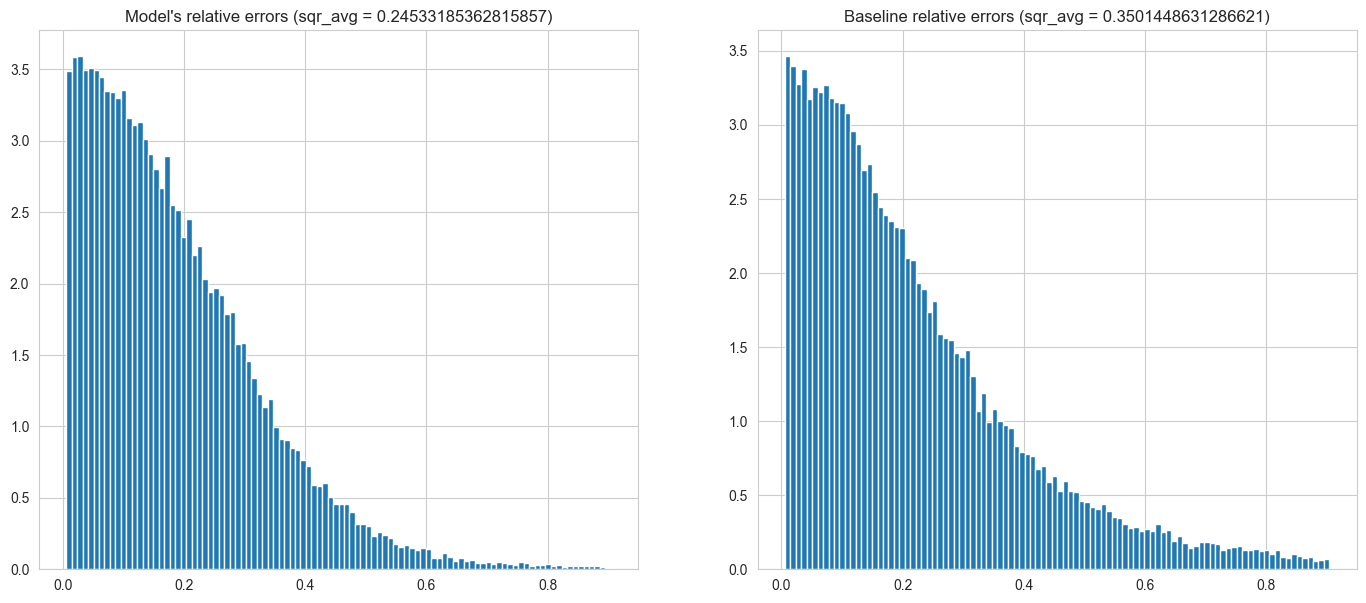

In [32]:
import matplotlib.pyplot as plt

def square_mean(data):
    return np.sqrt(np.square(data).mean())

fig, ax = plt.subplots(1, 2, figsize=(17,7))
ax1, ax2 = ax
quant1 = np.quantile(relative_errors_baseline, 0.02)
quant2 = np.quantile(relative_errors_baseline, 0.98)
ax1.hist(relative_errors_model, bins=100, density=True, range=(quant1, quant2))
ax1.set_title(f"Model's relative errors (sqr_avg = {square_mean(relative_errors_model)})")

ax2.hist(relative_errors_baseline, bins=100, density=True, range=(quant1, quant2))
ax2.set_title(f"Baseline relative errors (sqr_avg = {square_mean(relative_errors_baseline)})")

In [34]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test.cpu(), preds.cpu())
print(r2)

0.7569420341028912


In [ ]:
baseline_preds = X[:, 0]
print(torch.sqrt(torch.mean(torch.square((baseline_preds - y) / y))).item())

In [ ]:
model = model.to('cpu')
model.eval()
torch.save(model.state_dict(), f"../residual_mlp.pt")

In [ ]:
pd.plotting.hist_frame(df[(df['sigma'] <= quant2) & (df['target'] <= quant2)].loc[:, ['sigma', 'target', 'size', 'timefunc', 'log_size', 'spread']], bins=100)
plt.tight_layout()

In [120]:
X.shape

torch.Size([428910, 5])

In [146]:
X_train[:10]

tensor([[ 1.9763,  1.7561, 10.7565,  0.6604,  1.3863],
        [ 4.0684,  2.6710, 12.1320,  0.7606,  1.3863],
        [ 6.1765,  5.7527,  9.8222,  0.5117,  1.6094],
        [ 9.1875, 13.5314,  9.3642,  0.8357,  1.7918],
        [ 2.7548,  5.4930,  8.1708,  0.3096,  2.5649],
        [ 3.0273,  4.5923,  9.0214,  0.6171,  2.5649],
        [ 5.9866,  6.5896,  9.3689,  0.0587,  1.9459],
        [ 2.8718,  4.4918,  9.2857,  0.4352,  2.1972],
        [ 2.8515,  4.3059,  8.6881,  0.8697,  2.3979],
        [ 3.1476,  4.5328,  8.6689,  0.7378,  2.9444]])

In [35]:
from xgboost import XGBRegressor
model_xgb = XGBRegressor(n_estimators=10000, max_depth=3)
model_xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=10000,
             n_jobs=None, num_parallel_tree=None, ...)

In [36]:
X_test = X_test.to('cpu')

In [37]:
preds_test = model_xgb.predict(X_test)
print(criterion(preds_test, y_test.cpu()))

tensor(0.3243)


In [39]:
r2_xgb_weak = r2_score(preds_test, y_test.cpu())
print(r2_xgb_weak)

0.707125154145428


In [43]:
print(dataloader.dataset[0][0].shape[-1])

6
